# **Data Wrangling Project**

Proposed task                           | Goal
----------------------------------------|------------------------------------------------------
Loading and Inspecting timeseries data | Explore and understand the data
Handling missing values                | Complete the timeseries
Dealing with outliers                  | Identify and manage anomalies in the time series
Resampling and aggregation             | Grouping and aggregation to improve insights
Feature engineering                    | Create additional columns for analysis
Normalization and scaling              | Standardize the range of the features
Import additional data                 | Enrich the dataset to more layered insights
“Putting all together”                 | Combine and finalize the results of tasks above


## Loading and Inspecting timeseries data

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
salesdata = pd.read_csv("salesdata.csv", sep = ';')
salesdata

,Date,Location,Product,Sales
0,2022.10.02,Location A,Bread,405
1,2022.10.02,Location A,Pastry,306
2,2022.10.02,Location A,Croissant,345
3,2022.10.02,Location C,Pastry,178
4,2022.10.02,Location C,Croissant,200
...,...,...,...,...
5154,2021.01.01,Location A,Pastry,168
5155,2021.01.01,Location C,Bread,86
5156,2021.01.01,Location C,Pastry,69
5157,2021.01.01,Location B,Bread,80


In [ ]:
salesdata.dtypes

,0
Date,object
Location,object
Product,object
Sales,int64


Changing datatypes

In [ ]:
salesdata["Location"] = salesdata["Location"].astype("category")
salesdata["Product"] = salesdata["Product"].astype("category")

Counting values

In [ ]:
salesdata["Product"].value_counts()

,count
Product,
Bread,1873
Pastry,1853
Croissant,1433


In [ ]:
salesdata["Location"].value_counts()

,count
Location,
Location A,1728
Location B,1721
Location C,1710


What is the time range?

In [ ]:
salesdata['Date'] = pd.to_datetime(salesdata['Date'])

In [ ]:
start_date = salesdata['Date'].min()
end_date = salesdata['Date'].max()

print(f"The time series starts on {start_date} and ends on {end_date}.")

The time series starts on 2021-01-01 00:00:00 and ends on 2022-10-02 00:00:00.


In [ ]:
date_diffs = salesdata['Date'].sort_values().diff().dropna()
print("Most common difference between dates:")
print(date_diffs.mode())
#It means they record sale numbers everyday

Most common difference between dates:
0   0 days
Name: Date, dtype: timedelta64[ns]


Lets see a visualization about the total Sales

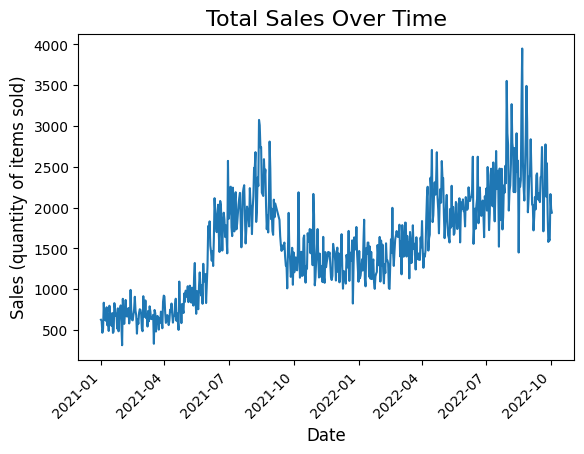

In [ ]:
salesdata.groupby("Date")["Sales"].sum().plot()

plt.title("Total Sales Over Time", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Sales (quantity of items sold)", fontsize=12)

plt.xticks(rotation=45)
plt.show()

##Handling Missing Values

Lets see if we have null values

In [ ]:
salesdata.isna().sum()

,0
Date,0
Location,0
Product,0
Sales,0


There are more missing records for each combination of date, location, and product

In [ ]:
salesdata["Date"].value_counts()[salesdata["Date"].value_counts()<9]

,count
Date,
2021-10-17,8
2021-11-24,8
2021-07-30,8
2021-08-28,8
2021-07-31,8
...,...
2021-03-17,4
2021-02-21,4
2021-02-22,4


We are looking for those dates which are not available in our dataset

In [ ]:
all_dates = salesdata['Date'].unique()
all_locations = salesdata['Location'].unique()
all_products = salesdata['Product'].unique()

full_record = pd.MultiIndex.from_product(
    [all_dates, all_locations, all_products],
    names=['Date', 'Location', 'Product']
)

salesdata_newindex = salesdata.set_index(['Date', 'Location', 'Product'])

#Using reindex to match our expected record into our data, reindex will add more row if the row is missing in our data
salesdata_full = salesdata_newindex.reindex(full_record)

#Filling missing Sales with 0, assume that the bakery sold no products that day
salesdata_full['Sales'] = salesdata_full['Sales'].fillna(0).astype(int)

salesdata = salesdata_full.reset_index()

Checking which dates have missing records

In [ ]:
salesdata[salesdata["Sales"] == 0]

,Date,Location,Product,Sales
188,2022-09-12,Location B,Croissant,0
293,2022-08-31,Location C,Croissant,0
302,2022-08-30,Location C,Croissant,0
307,2022-08-29,Location A,Pastry,0
402,2022-08-19,Location B,Bread,0
...,...,...,...,...
5702,2021-01-02,Location C,Croissant,0
5705,2021-01-02,Location B,Croissant,0
5708,2021-01-01,Location A,Croissant,0
5711,2021-01-01,Location C,Croissant,0


##Outlier Handling

Using boxplot, we can observe the outliers in total, then by Product and Location

<Axes: >

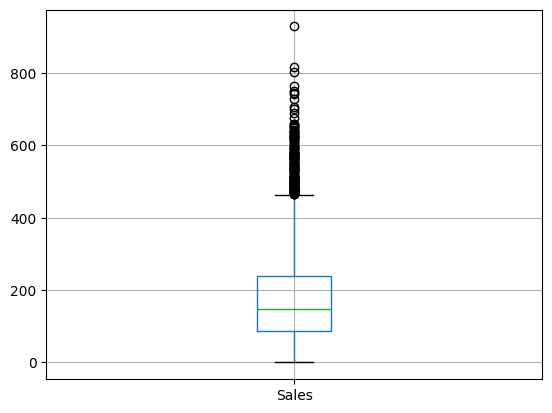

In [ ]:
salesdata.boxplot(column="Sales")

<Axes: title={'center': 'Sales'}, xlabel='Product'>

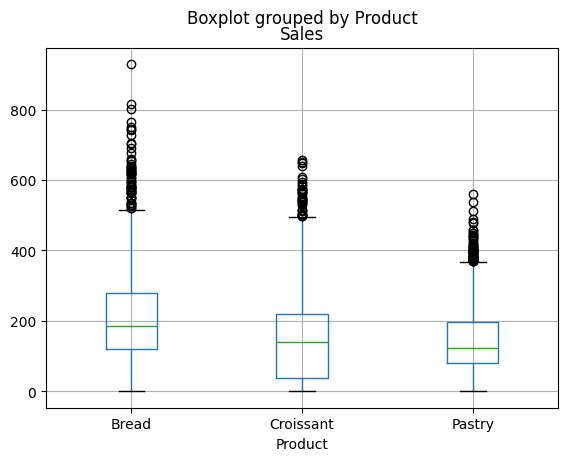

In [ ]:
salesdata.boxplot("Sales", by="Product")

<Axes: title={'center': 'Sales'}, xlabel='Location'>

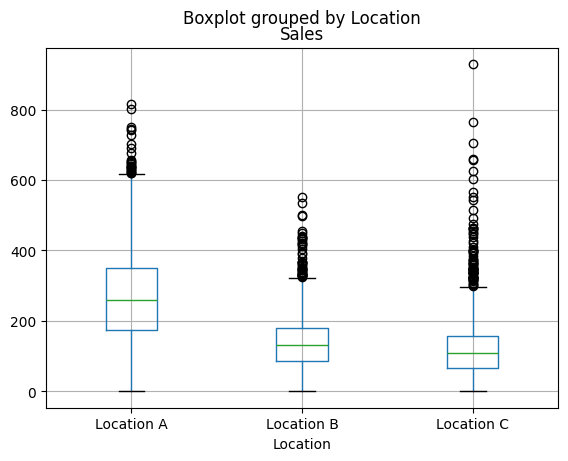

In [ ]:
salesdata.boxplot("Sales", by="Location")

Our first approach: using 99th percentile, we change the outliers' values

In [ ]:
percentile_99 = round(np.percentile(salesdata["Sales"], 99),0)
print(percentile_99)
salesdata['Capped_Sales'] = np.where(salesdata["Sales"]>=percentile_99, percentile_99, salesdata["Sales"])

569.0


We can chank the 10 greatest Sales value

In [ ]:
salesdata["Sales"].nlargest(10)


,Sales
381,929
1413,816
1026,802
318,764
1278,751
783,744
1584,742
1458,729
336,706
1404,701


In [ ]:
salesdata["Capped_Sales"].nlargest(10)

,Capped_Sales
20,569.0
63,569.0
81,569.0
279,569.0
299,569.0
315,569.0
318,569.0
324,569.0
326,569.0
327,569.0


We successfully changed those values

Lets see the boxplot for this capped sales in total, by product and by location

<Axes: >

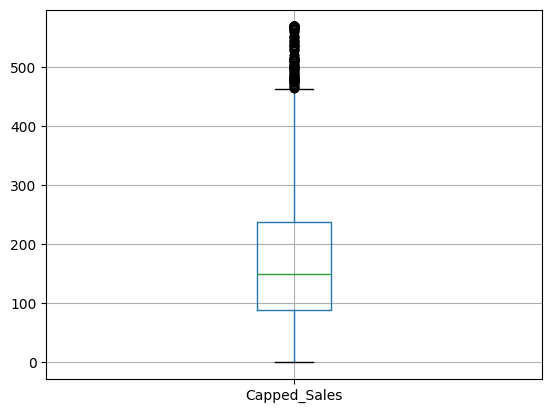

In [ ]:
salesdata.boxplot("Capped_Sales")

<Axes: title={'center': 'Capped_Sales'}, xlabel='Product'>

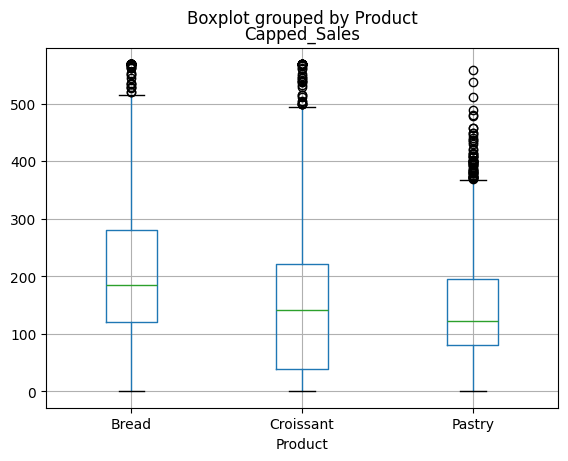

In [ ]:
salesdata.boxplot("Capped_Sales", by="Product")

<Axes: title={'center': 'Capped_Sales'}, xlabel='Location'>

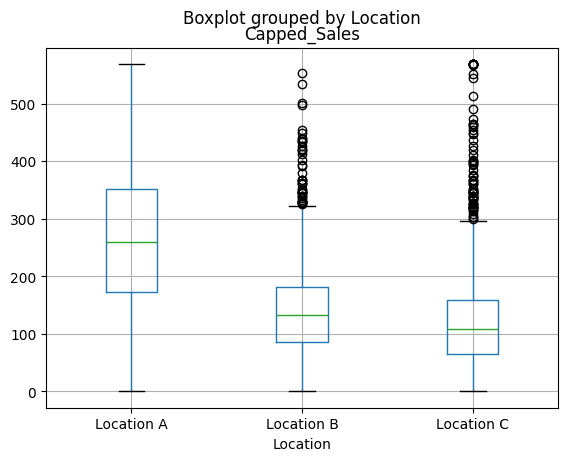

In [ ]:
salesdata.boxplot("Capped_Sales", by="Location")

But how many data did we changed?

In [ ]:
salesdata.loc[salesdata["Capped_Sales"]==percentile_99,"Sales"].count()

np.int64(59)

With this method we changed 54 values

Second approach: rolling average

In [ ]:
salesdata['Rolling_Sales'] = salesdata.groupby(['Product', 'Location'])['Sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())


<ipython-input-64-bec324ceb850>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salesdata['Rolling_Sales'] = salesdata.groupby(['Product', 'Location'])['Sales'].transform(lambda x: x.rolling(window=7, min_periods=1).mean())


Check the boxplot for this as well

<Axes: >

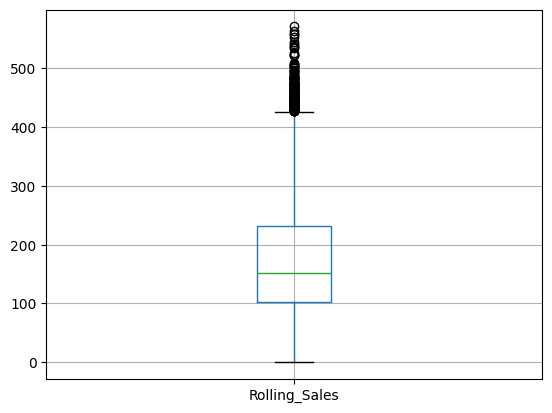

In [ ]:
salesdata.boxplot("Rolling_Sales")

Our choice is the second approach for further analysis, because it seems slightly smoother compared to the capped sales (when we changed the value of the ourliers)

Now lets examine further the sales data accoring to the rolling sales

<Axes: title={'center': 'Rolling_Sales'}, xlabel='[Product, Location]'>

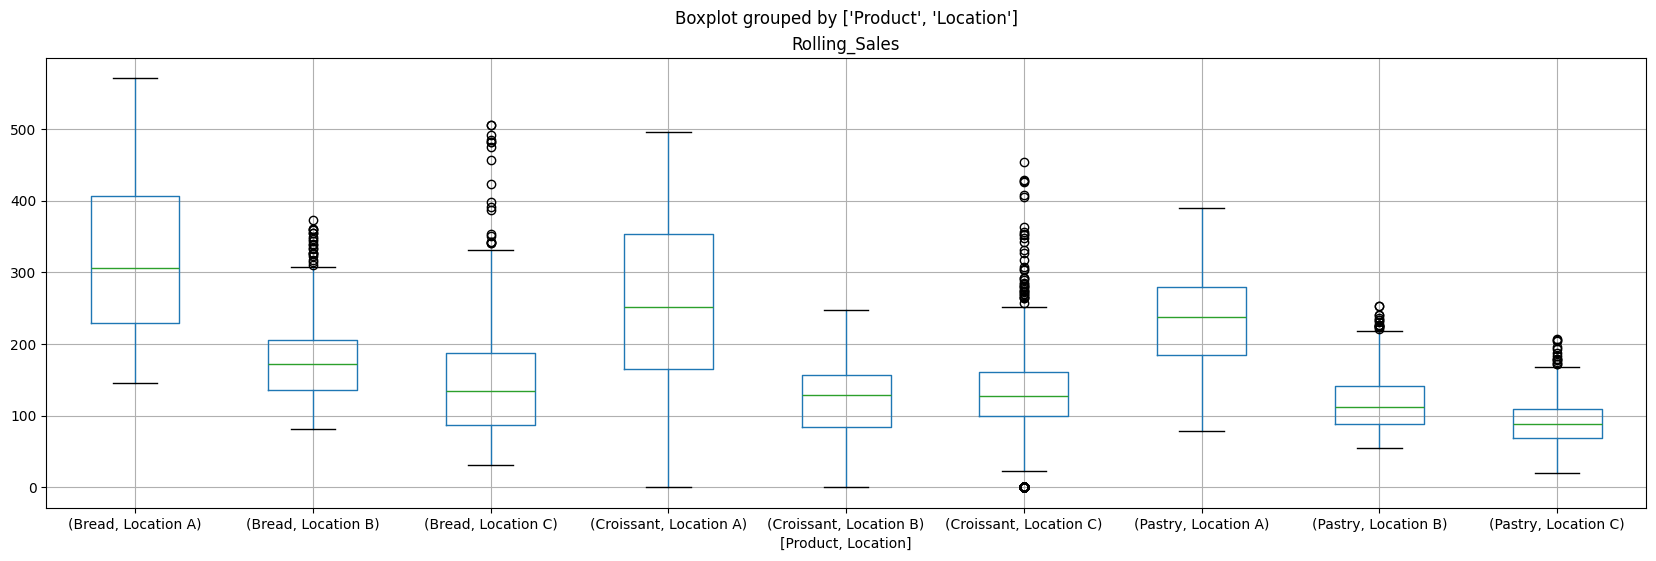

In [ ]:
salesdata.boxplot(column="Rolling_Sales", by=["Product", "Location"], figsize=(20, 6))



<Axes: title={'center': 'Rolling_Sales'}, xlabel='[Location, Product]'>

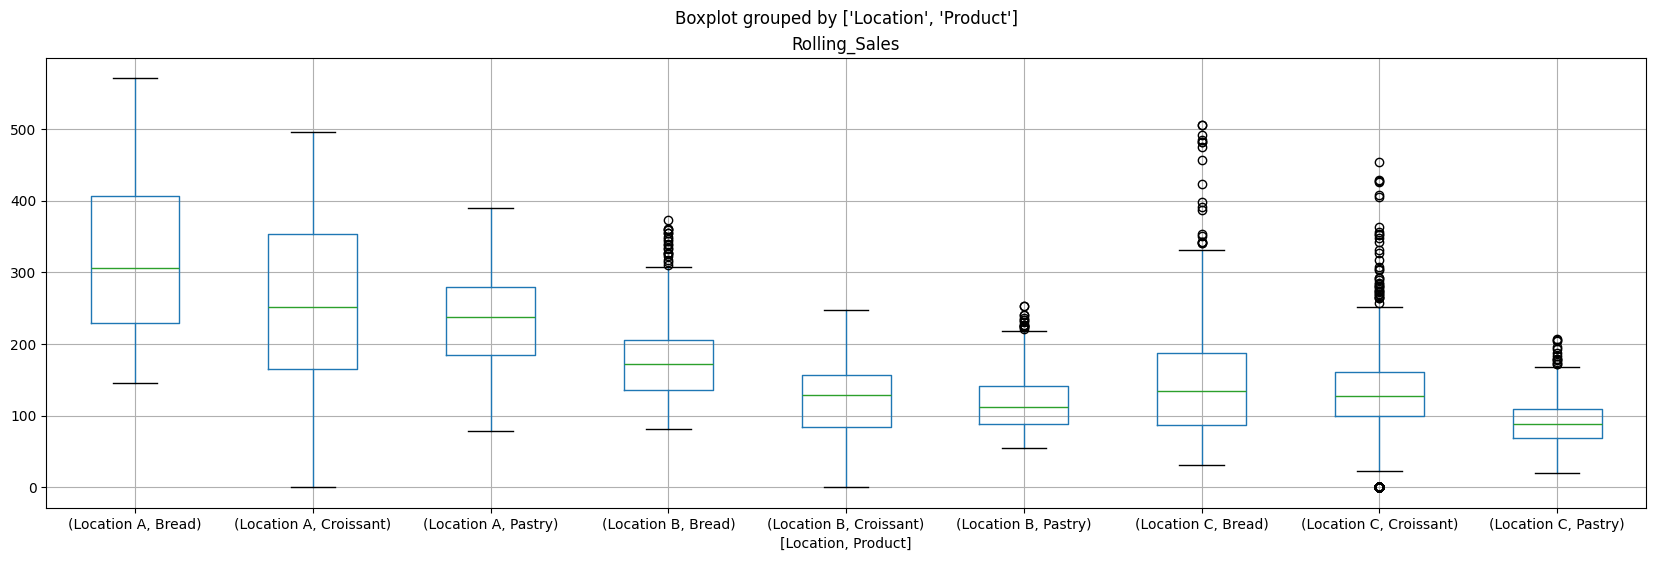

In [ ]:
salesdata.boxplot(column="Rolling_Sales", by=["Location", "Product"], figsize=(20, 6))

In [ ]:
salesdata.head()

,Date,Location,Product,Sales,Capped_Sales,Rolling_Sales
0,2022-10-02,Location A,Bread,405,405.0,405.0
1,2022-10-02,Location A,Pastry,306,306.0,306.0
2,2022-10-02,Location A,Croissant,345,345.0,345.0
3,2022-10-02,Location C,Bread,201,201.0,201.0
4,2022-10-02,Location C,Pastry,178,178.0,178.0


##Resampling and Aggregating

Lets make a resampling to weekly frequency using the average

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

salesdata_weekly = salesdata.copy() # to make sure we do not mess up our dataset
salesdata_weekly['Date'] = pd.to_datetime(salesdata_weekly['Date'])

weekly_avg = (
    salesdata_weekly
    .set_index('Date')
    .groupby(['Product', 'Location'])
    .resample('W')['Rolling_Sales']
    .mean()
    .reset_index()
)


print(weekly_avg.head(5))


  Product    Location       Date  Rolling_Sales
0   Bread  Location A 2021-01-03     201.047619
1   Bread  Location A 2021-01-10     195.183673
2   Bread  Location A 2021-01-17     241.265306
3   Bread  Location A 2021-01-24     201.448980
4   Bread  Location A 2021-01-31     187.204082


<ipython-input-69-bb1a8e930803>:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(['Product', 'Location'])


Visualizing the weekly sales by product to see their trends

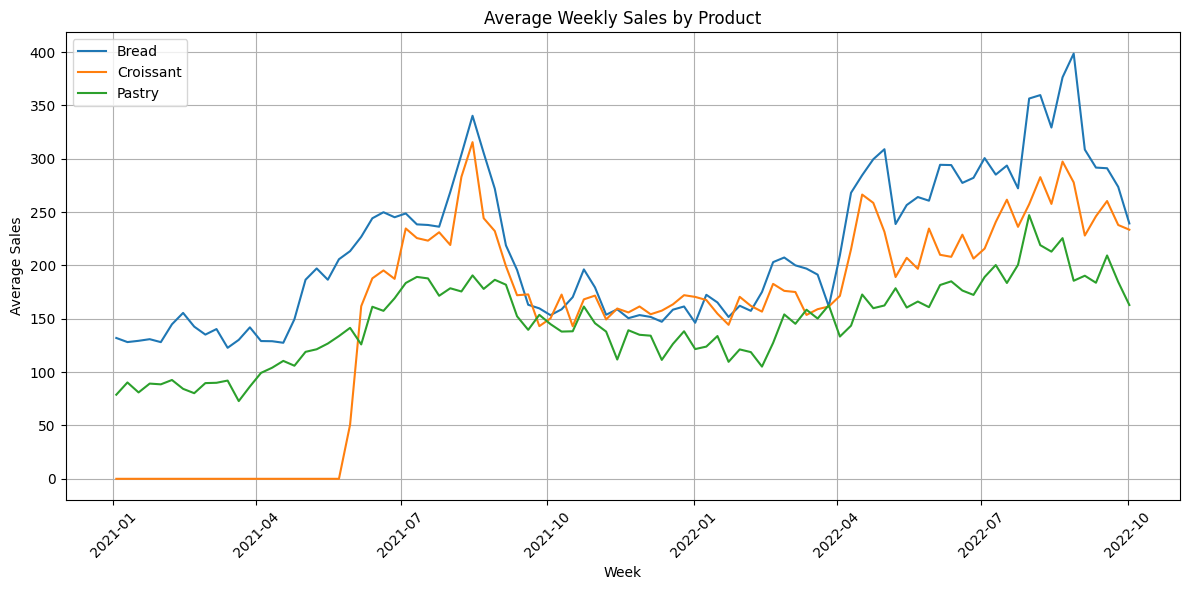

In [ ]:
plt.figure(figsize=(12, 6))
for product in weekly_avg['Product'].unique():
    product_data = weekly_avg[weekly_avg['Product'] == product]
    temp = product_data.groupby('Date')['Rolling_Sales'].mean()
    plt.plot(temp.index, temp.values, label=product)

plt.title('Average Weekly Sales by Product')
plt.xlabel('Week')
plt.ylabel('Average Sales')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.grid(True)
plt.show()


Lets make a heatmap of weekly average sales by product

<ipython-input-71-3d75970a11a0>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = weekly_avg.pivot_table(values='Rolling_Sales', index='Date', columns='Product', aggfunc='mean')


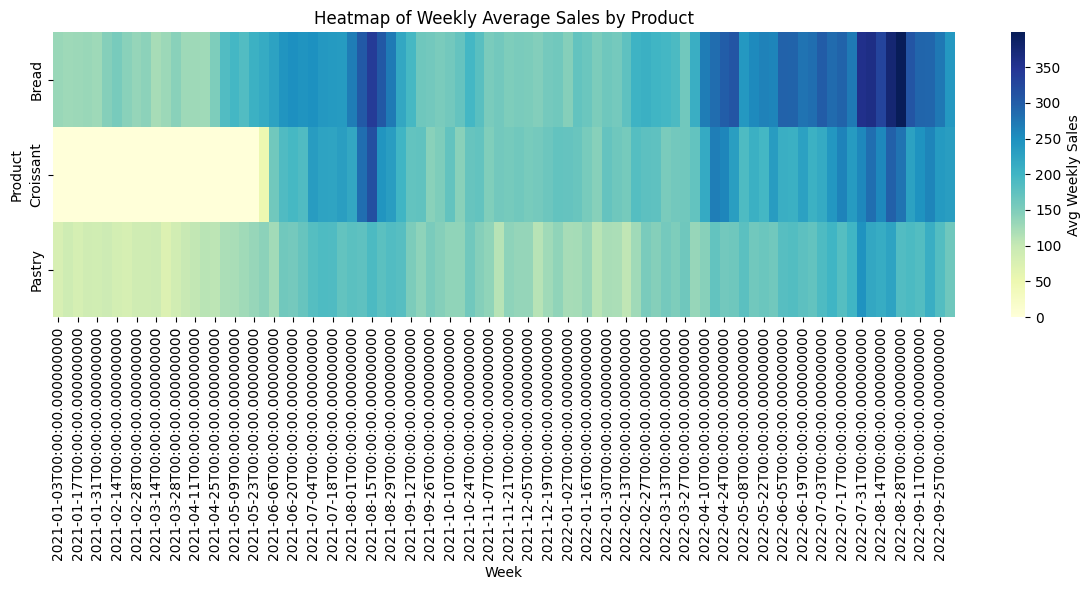

In [ ]:
heatmap_data = weekly_avg.pivot_table(values='Rolling_Sales', index='Date', columns='Product', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data.T, cmap="YlGnBu", cbar_kws={'label': 'Avg Weekly Sales'})
plt.title("Heatmap of Weekly Average Sales by Product")
plt.xlabel("Week")
plt.ylabel("Product")
plt.tight_layout()
plt.show()

Now lets see by location

<ipython-input-72-185383f992ea>:1: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  heatmap_data = weekly_avg.pivot_table(values='Rolling_Sales', index='Date', columns='Location', aggfunc='mean')


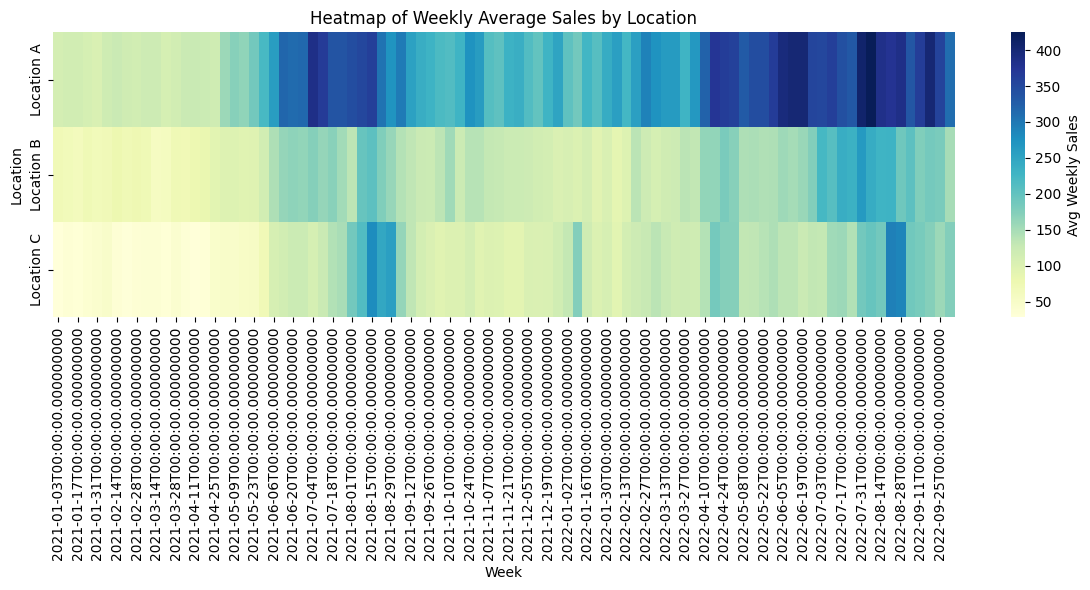

In [ ]:
heatmap_data = weekly_avg.pivot_table(values='Rolling_Sales', index='Date', columns='Location', aggfunc='mean')

plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data.T, cmap="YlGnBu", cbar_kws={'label': 'Avg Weekly Sales'})
plt.title("Heatmap of Weekly Average Sales by Location")
plt.xlabel("Week")
plt.ylabel("Location")
plt.tight_layout()
plt.show()

Now lets see the total sales by product and location

<ipython-input-73-dff728ce2bbe>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_sales = salesdata.groupby(['Product', 'Location'])['Rolling_Sales'].agg(['sum', 'mean', 'median', 'std'])


                                sum        mean      median         std
Product   Location                                                     
Bread     Location A  203550.280952  320.551624  306.000000  101.485401
          Location B  112693.857143  177.470641  172.000000   56.342957
          Location C   93878.342857  147.839910  134.571429   80.312631
Croissant Location A  148274.369048  233.502943  251.714286  146.238039
          Location B   71335.159524  112.338834  128.857143   69.269883
          Location C   77122.011905  121.451987  128.000000   83.541183
Pastry    Location A  147533.033333  232.335486  237.142857   63.923083
          Location B   75781.947619  119.341650  112.142857   39.537429
          Location C   57116.761905   89.947657   88.285714   32.191623


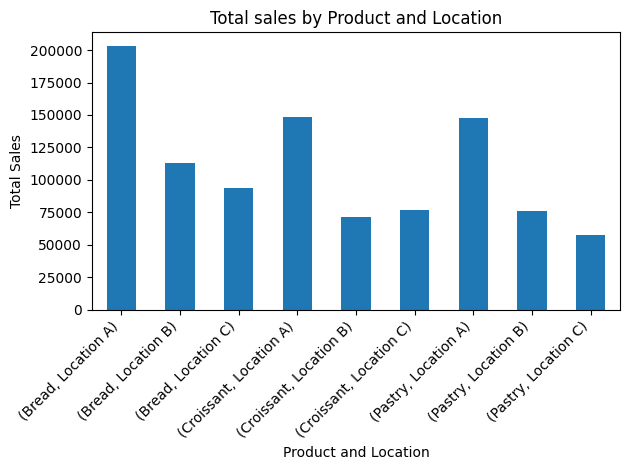

In [ ]:
grouped_sales = salesdata.groupby(['Product', 'Location'])['Rolling_Sales'].agg(['sum', 'mean', 'median', 'std'])

# Display the grouped and aggregated data
print(grouped_sales)



# Plotting aggregated sales
grouped_sales['sum'].plot(kind='bar')
plt.title("Total sales by Product and Location")
plt.xlabel("Product and Location")
plt.ylabel("Total Sales")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



##Feature Engineering

Lets make new columns for the year, month and day with the appropriate datatypes

In [ ]:
salesdata.head()

,Date,Location,Product,Sales,Capped_Sales,Rolling_Sales
0,2022-10-02,Location A,Bread,405,405.0,405.0
1,2022-10-02,Location A,Pastry,306,306.0,306.0
2,2022-10-02,Location A,Croissant,345,345.0,345.0
3,2022-10-02,Location C,Bread,201,201.0,201.0
4,2022-10-02,Location C,Pastry,178,178.0,178.0


In [ ]:
salesdata["Date"] = salesdata["Date"].astype(str)
salesdata[["Year", "Month", "Day"]] = salesdata["Date"].str.split("-", expand = True)
salesdata['Date'] = pd.to_datetime(salesdata['Date'])
salesdata['Month'] = salesdata['Month'].astype(int)
salesdata['Year'] = salesdata['Year'].astype(int)
salesdata['Day'] = salesdata['Day'].astype(int)
salesdata["Date"] = pd.to_datetime(salesdata["Date"])

Lets construct a category column where we group the sales according to the sales frequency

In [ ]:
#making groups according to the amount of sales
group_names = ['less than 100',"between 100 and 250", "between 250 and 500","more than 500"]
# Instead of calling max on salesdata["Rolling_Sales"] directly in the bins list,
# calculate the maximum value beforehand and store it in a variable.
max_rolling_sales = salesdata["Rolling_Sales"].max()
salesdata['Sales_group'] = pd.cut(x=salesdata["Rolling_Sales"], bins=[0,100,250,500,max_rolling_sales], labels=group_names)

Lets see the frequency table of the new category

In [ ]:
salesdata.groupby("Sales_group")["Rolling_Sales"].count()

<ipython-input-77-574f194a2fde>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salesdata.groupby("Sales_group")["Rolling_Sales"].count()


,Rolling_Sales
Sales_group,
less than 100,946
between 100 and 250,3168
between 250 and 500,1144
more than 500,22


Generating 7-14-28 lagged values

In [ ]:
for lag in [7, 14, 28]:
    salesdata[f'Sales_lag_{lag}'] = salesdata.groupby(['Product', 'Location'])['Rolling_Sales'].shift(lag)


<ipython-input-78-37732c9a7c04>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salesdata[f'Sales_lag_{lag}'] = salesdata.groupby(['Product', 'Location'])['Rolling_Sales'].shift(lag)
<ipython-input-78-37732c9a7c04>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salesdata[f'Sales_lag_{lag}'] = salesdata.groupby(['Product', 'Location'])['Rolling_Sales'].shift(lag)
<ipython-input-78-37732c9a7c04>:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and

Lets check the null values of these

In [ ]:
salesdata["Sales_lag_7"].isna().sum()

np.int64(63)

In [ ]:
salesdata["Sales_lag_14"].isna().sum()

np.int64(126)

In [ ]:
salesdata["Sales_lag_28"].isna().sum()

np.int64(252)

How does our dataset look so far?

In [ ]:
salesdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5715 entries, 0 to 5714
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           5715 non-null   datetime64[ns]
 1   Location       5715 non-null   category      
 2   Product        5715 non-null   category      
 3   Sales          5715 non-null   int64         
 4   Capped_Sales   5715 non-null   float64       
 5   Rolling_Sales  5715 non-null   float64       
 6   Year           5715 non-null   int64         
 7   Month          5715 non-null   int64         
 8   Day            5715 non-null   int64         
 9   Sales_group    5280 non-null   category      
 10  Sales_lag_7    5652 non-null   float64       
 11  Sales_lag_14   5589 non-null   float64       
 12  Sales_lag_28   5463 non-null   float64       
dtypes: category(3), datetime64[ns](1), float64(5), int64(4)
memory usage: 463.8 KB


In [ ]:
salesdata.head(5)

,Date,Location,Product,Sales,Capped_Sales,Rolling_Sales,Year,Month,Day,Sales_group,Sales_lag_7,Sales_lag_14,Sales_lag_28
0,2022-10-02,Location A,Bread,405,405.0,405.0,2022,10,2,between 250 and 500,NaN,NaN,NaN
1,2022-10-02,Location A,Pastry,306,306.0,306.0,2022,10,2,between 250 and 500,NaN,NaN,NaN
2,2022-10-02,Location A,Croissant,345,345.0,345.0,2022,10,2,between 250 and 500,NaN,NaN,NaN
3,2022-10-02,Location C,Bread,201,201.0,201.0,2022,10,2,between 100 and 250,NaN,NaN,NaN
4,2022-10-02,Location C,Pastry,178,178.0,178.0,2022,10,2,between 100 and 250,NaN,NaN,NaN


##Normalization and Scaling

Our first approach: we apply min-max scaling, we use the total Sales

In [ ]:
min = salesdata['Sales'].min()
max = salesdata['Sales'].max()
salesdata['Sales_normalized'] = (salesdata['Sales']-min)/(max-min)

Our second approach: here we group by Location and Product because it is more suitable

In [ ]:
salesdata['Sales_scaled'] = salesdata.groupby(['Location', 'Product'])['Sales']\
    .transform(lambda x: (x - x.min()) / (x.max() - x.min()))



<ipython-input-85-254b7fa8f5ca>:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  salesdata['Sales_scaled'] = salesdata.groupby(['Location', 'Product'])['Sales']\


In [ ]:
salesdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5715 entries, 0 to 5714
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              5715 non-null   datetime64[ns]
 1   Location          5715 non-null   category      
 2   Product           5715 non-null   category      
 3   Sales             5715 non-null   int64         
 4   Capped_Sales      5715 non-null   float64       
 5   Rolling_Sales     5715 non-null   float64       
 6   Year              5715 non-null   int64         
 7   Month             5715 non-null   int64         
 8   Day               5715 non-null   int64         
 9   Sales_group       5280 non-null   category      
 10  Sales_lag_7       5652 non-null   float64       
 11  Sales_lag_14      5589 non-null   float64       
 12  Sales_lag_28      5463 non-null   float64       
 13  Sales_normalized  5715 non-null   float64       
 14  Sales_scaled      5715 n

In [ ]:
salesdata.head(30)

,Date,Location,Product,Sales,Capped_Sales,Rolling_Sales,Year,Month,Day,Sales_group,Sales_lag_7,Sales_lag_14,Sales_lag_28,Sales_normalized,Sales_scaled
0,2022-10-02,Location A,Bread,405,405.0,405.000000,2022,10,2,between 250 and 500,NaN,NaN,NaN,0.435953,0.496324
1,2022-10-02,Location A,Pastry,306,306.0,306.000000,2022,10,2,between 250 and 500,NaN,NaN,NaN,0.329386,0.547406
2,2022-10-02,Location A,Croissant,345,345.0,345.000000,2022,10,2,between 250 and 500,NaN,NaN,NaN,0.371367,0.530769
3,2022-10-02,Location C,Bread,201,201.0,201.000000,2022,10,2,between 100 and 250,NaN,NaN,NaN,0.216362,0.216362
4,2022-10-02,Location C,Pastry,178,178.0,178.000000,2022,10,2,between 100 and 250,NaN,NaN,NaN,0.191604,0.561514
5,2022-10-02,Location C,Croissant,200,200.0,200.000000,2022,10,2,between 100 and 250,NaN,NaN,NaN,0.215285,0.303951
6,2022-10-02,Location B,Bread,108,108.0,108.000000,2022,10,2,between 100 and 250,NaN,NaN,NaN,0.116254,0.195298
7,2022-10-02,Location B,Pastry,105,105.0,105.000000,2022,10,2,between 100 and 250,NaN,NaN,NaN,0.113025,0.238636
8,2022-10-02,Location B,Croissant,90,90.0,90.000000,2022,10,2,less than 100,NaN,NaN,NaN,0.096878,0.207852
9,2022-10-01,Location A,Bread,304,304.0,354.500000,2022,10,1,between 250 and 500,NaN,NaN,NaN,0.327234,0.372549


##Import Additional Data

We have encoding problem so we need the chardet library in order to read the csv file

In [ ]:
import chardet

# Read a sample of the file as raw bytes
raw = open("stadat-ara0041-1.2.1.3-hu.csv", 'rb').read(10000)
detected = chardet.detect(raw)
print(detected)

# Then pass the detected encoding to pandas
cpi = pd.read_csv("stadat-ara0041-1.2.1.3-hu.csv",
                  sep=';',
                  encoding=detected['encoding'],
                  header=1)


{'encoding': 'ISO-8859-1', 'confidence': 0.73, 'language': ''}


In [ ]:
cpi.head()

,Sorszám,"Áru-, szolgáltatáscsoportok",2021. Súly,2021. január,2021. február,2021. március,2021. április,2021. május,2021. június,2021. július,...,2025. március,2025. április,2025. május,2025. június,2025. július,2025. augusztus,2025. szeptember,2025. október,2025. november,2025. december
0,"Az elõzõ év azonos idõszaka = 100,0%",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,100,Sertéshús,"1,288","93,7","92,7","92,2","93,1","92,5","94,4","97,4",...,"101,6","97,0",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,101,Marhahús,"0,091","103,6","103,7","103,8","101,7","102,3","101,8","102,1",...,"107,1","105,9",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,102,Egyéb hús,"0,019","100,7","99,2","98,5","98,4","101,0","99,9","100,4",...,"106,8","106,7",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,103,Belsõségek,"0,117","103,0","103,2","102,6","99,6","101,1","104,3","105,9",...,"103,1","102,8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We only need the bread and pastry data

In [ ]:
bread_pastry = cpi.loc[
    (cpi["Áru-, szolgáltatáscsoportok"] == "Kenyér") |
    (cpi["Áru-, szolgáltatáscsoportok"] == "Péksütemények")
]

bread_pastry = bread_pastry.iloc[:-4]
bread_pastry

,Sorszám,"Áru-, szolgáltatáscsoportok",2021. Súly,2021. január,2021. február,2021. március,2021. április,2021. május,2021. június,2021. július,...,2025. március,2025. április,2025. május,2025. június,2025. július,2025. augusztus,2025. szeptember,2025. október,2025. november,2025. december
25,132,Kenyér,"1,036","106,0","105,4","104,6","105,2","104,9","105,3","104,0",...,"106,5","106,8",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,133,Péksütemények,"0,818","104,8","105,7","105,5","105,3","104,5","105,6","105,5",...,"104,7","106,5",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We need to exchange the rows and columns to fit to the salesdata dataset

In [ ]:
bread_pastry = bread_pastry.T

In [ ]:
bread_pastry

,25,26
Sorszám,132,133
"Áru-, szolgáltatáscsoportok",Kenyér,Péksütemények
2021. Súly,"1,036","0,818"
2021. január,"106,0","104,8"
2021. február,"105,4","105,7"
...,...,...
2025. augusztus,NaN,NaN
2025. szeptember,NaN,NaN
2025. október,NaN,NaN
2025. november,NaN,NaN


We do not need the first 3 rows, so lets drop them



In [ ]:
bread_pastry= bread_pastry.iloc[3:]

bread_pastry.info()

<class 'pandas.core.frame.DataFrame'>
Index: 64 entries, 2021. január to 2025. december
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   25      56 non-null     object
 1   26      56 non-null     object
dtypes: object(2)
memory usage: 1.5+ KB


Lets rename the columns for Bread and Pastry

In [ ]:
bread_pastry.columns = ['Bread', 'Pastry']


We need to replace the commas with dots

In [ ]:
bread_pastry["Bread"].str.replace(",", ".", regex=True).astype(float)
bread_pastry["Pastry"].str.replace(",", ".", regex=True).astype(float)

,Pastry
2021. január,104.8
2021. február,105.7
2021. március,105.5
2021. április,105.3
2021. május,104.5
...,...
2025. augusztus,NaN
2025. szeptember,NaN
2025. október,NaN
2025. november,NaN


Now we ad a new index ( we do not want the Date as an index) and name the date column

In [ ]:
bread_pastry.reset_index(inplace=True)
bread_pastry.columns = ['Date', 'Bread', 'Pastry']
bread_pastry.head()

,Date,Bread,Pastry
0,2021. január,"106,0","104,8"
1,2021. február,"105,4","105,7"
2,2021. március,"104,6","105,5"
3,2021. április,"105,2","105,3"
4,2021. május,"104,9","104,5"


There are some rows where there is no Date but a summary line called "súly", so we would like to get rid of them

In [ ]:
bread_pastry = bread_pastry[~bread_pastry['Date'].str.contains("Súly", na=False)]



It can be seen that we have hungarian month name, we need to translate them to english in order to change the datatype of them

In [ ]:
month_map = {
    "január": "January", "február": "February", "március": "March",
    "április": "April", "május": "May", "június": "June",
    "július": "July", "augusztus": "August", "szeptember": "September",
    "október": "October", "november": "November", "december": "December"
}

bread_pastry['Date'] = bread_pastry['Date'].replace(month_map, regex=True)
bread_pastry['Date'] = pd.to_datetime(bread_pastry['Date'], format="%Y. %B")


<ipython-input-98-70162359b733>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bread_pastry['Date'] = bread_pastry['Date'].replace(month_map, regex=True)
<ipython-input-98-70162359b733>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bread_pastry['Date'] = pd.to_datetime(bread_pastry['Date'], format="%Y. %B")


In [ ]:
bread_pastry

,Date,Bread,Pastry
0,2021-01-01,"106,0","104,8"
1,2021-02-01,"105,4","105,7"
2,2021-03-01,"104,6","105,5"
3,2021-04-01,"105,2","105,3"
4,2021-05-01,"104,9","104,5"
5,2021-06-01,"105,3","105,6"
6,2021-07-01,"104,0","105,5"
7,2021-08-01,"104,7","105,1"
8,2021-09-01,"104,7","106,0"
9,2021-10-01,"108,1","108,4"


Lets create a new column for the year and month and change the type to datatime

In [ ]:
bread_pastry['YearMonth'] = bread_pastry['Date'].dt.to_period('M').astype(str)
bread_pastry['YearMonth'] = pd.to_datetime(bread_pastry['YearMonth'])


<ipython-input-100-80fe815bedae>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bread_pastry['YearMonth'] = bread_pastry['Date'].dt.to_period('M').astype(str)
<ipython-input-100-80fe815bedae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bread_pastry['YearMonth'] = pd.to_datetime(bread_pastry['YearMonth'])


We do not need the null values

In [ ]:
bread_pastry = bread_pastry.dropna(subset=['YearMonth', 'Bread', 'Pastry'])


Again we need to replace the commas to dots

In [ ]:
bread_pastry['Pastry'] = bread_pastry['Pastry'].astype(str).str.replace(',', '.', regex=False).astype(float)


<ipython-input-102-c53ef74a4b74>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bread_pastry['Pastry'] = bread_pastry['Pastry'].astype(str).str.replace(',', '.', regex=False).astype(float)


In [ ]:
bread_pastry['Bread'] = bread_pastry['Bread'].astype(str).str.replace(',', '.', regex=False).astype(float)


<ipython-input-103-b4019decb766>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bread_pastry['Bread'] = bread_pastry['Bread'].astype(str).str.replace(',', '.', regex=False).astype(float)


Now lets visualize the bread and pastry prices and compare them with our sales data

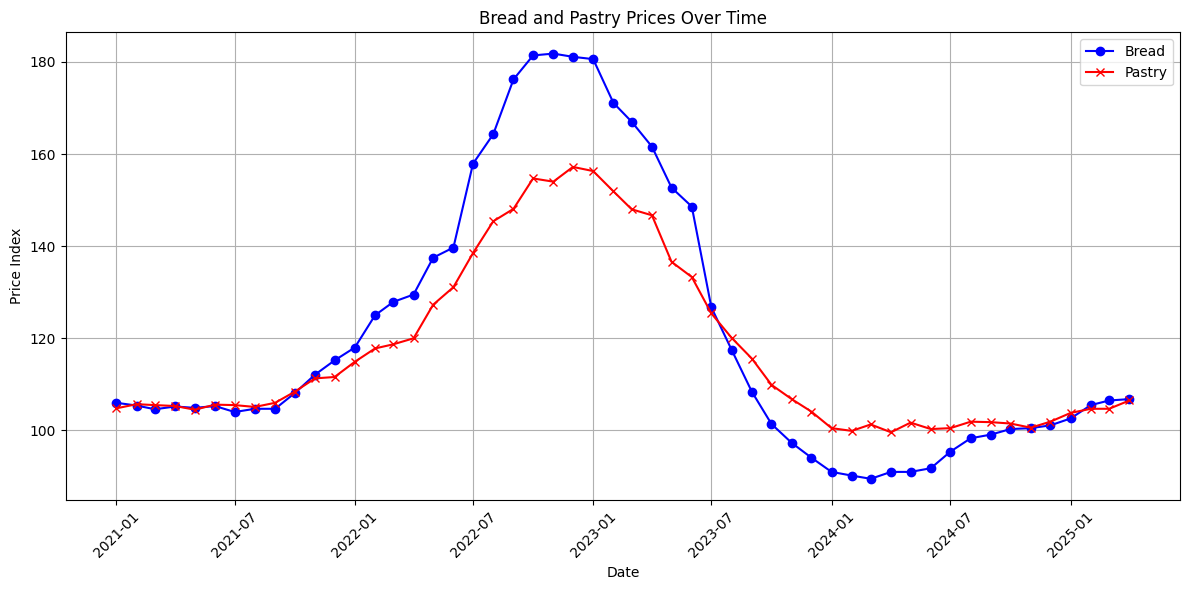

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(
bread_pastry['YearMonth'], bread_pastry["Bread"], label="Bread", marker='o', color='blue')
plt.plot(
bread_pastry['YearMonth'], bread_pastry["Pastry"], label="Pastry", marker='x', color='red')

plt.title("Bread and Pastry Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price Index")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Plot for the monthly sales by product

<ipython-input-105-b0d671acd2a9>:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for product, group in salesdata.groupby('Product'):


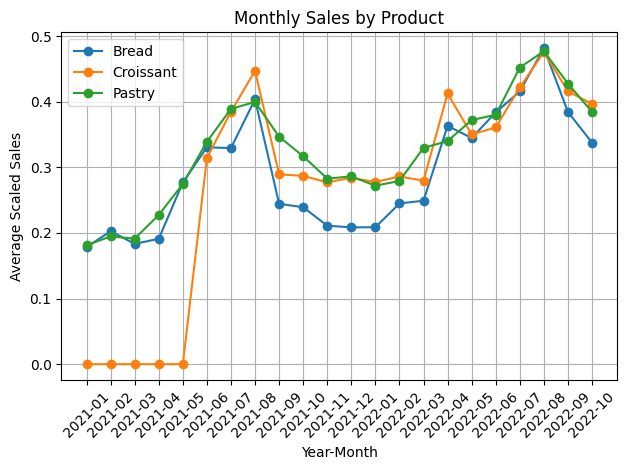

In [ ]:
salesdata['Date'] = pd.to_datetime(salesdata['Date'])

salesdata['YearMonth'] = salesdata['Date'].dt.to_period('M').astype(str)

# Group and plot
for product, group in salesdata.groupby('Product'):
    monthly = group.groupby('YearMonth')['Sales_scaled'].mean()
    plt.plot(monthly.index, monthly.values, marker='o', label=product)

# Plot settings
plt.title('Monthly Sales by Product')
plt.xlabel('Year-Month')
plt.ylabel('Average Scaled Sales')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Our plot of bread and pastry prices is a little bit different from the sales plot in the sense of x axis: we need to take into account those date which are less then 2022.10.30

In [ ]:
till2022 = bread_pastry.loc[bread_pastry["Date"]<"2022-11-01"]

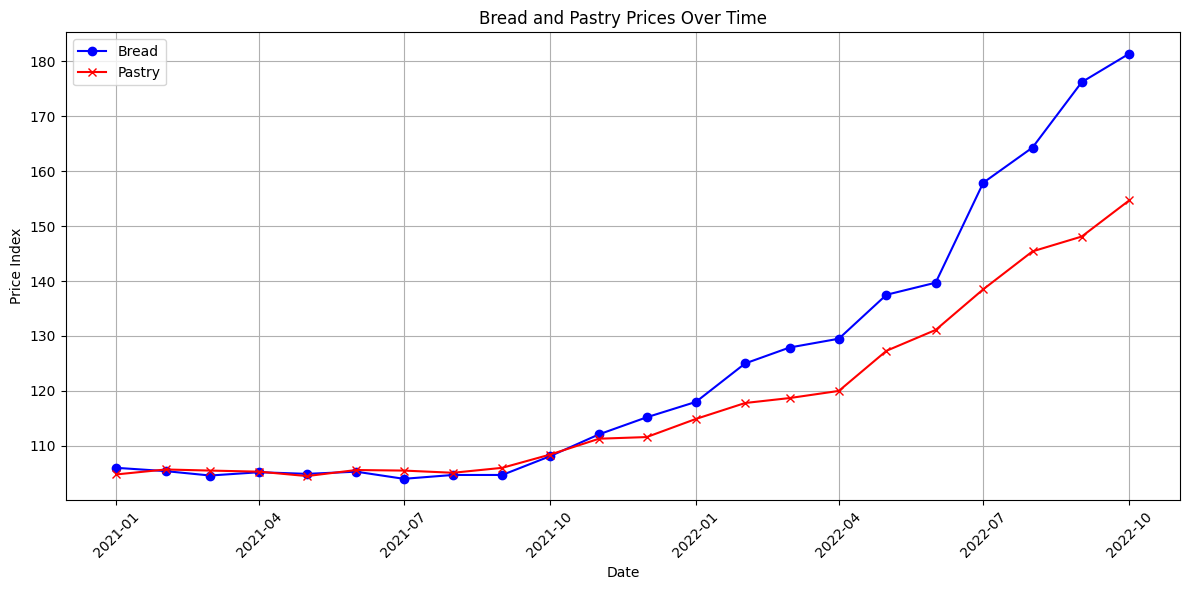

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(
till2022['YearMonth'], till2022["Bread"], label="Bread", marker='o', color='blue')
plt.plot(
till2022['YearMonth'], till2022["Pastry"], label="Pastry", marker='x', color='red')

plt.title("Bread and Pastry Prices Over Time")
plt.xlabel("Date")
plt.ylabel("Price Index")
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

Based on the two plots, they have opposite relationship and it might be weak as well

We need to extract the bread and pastry sales (we do not have price data for the croissant)

In [ ]:
salesdata_bread = salesdata[salesdata["Product"] == "Bread"]
salesdata_pastry = salesdata[salesdata["Product"] == "Pastry"]


Now finally lets see the correlation between the sales (normalized) and the price indices

In [ ]:
correlation_bread = salesdata_bread['Sales_scaled'].corr(till2022['Bread'])
print(correlation_bread)

-0.03492743990270421


In [ ]:
correlation_pastry = salesdata_pastry['Sales_scaled'].corr(till2022['Pastry'])
print(correlation_pastry)

0.002442918794092397


We can calculate the coefficient of determination as well

In [ ]:
(-0.3208629000470468)**2

0.10295300062660116

In [ ]:
(-0.31998317019396544)**2

0.10238922920738025

According to our data, the prices indices and the sales are moderately correlated, so we might use it for the fore cast, but also we have the neccessary data ( rolling average) to be able to make a prediction model
